## 1. Setup & данные

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import umap
import pandas as pd
import random
import os
from PIL import Image
import requests
from io import BytesIO
import time
import warnings
import seaborn as sns
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Установка дополнительных пакетов
!pip install umap-learn plotly opencv-python ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import clip
import cv2

# Фиксируем сиды
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bsfyjmob
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bsfyjmob
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=eacde90f4b6e557d41af777f13a688f8e644314baea830c024e6dd63a5e61bcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-y6_lokjp/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Используемое устройство: cuda


### Загрузка датасета

100%|██████████| 170M/170M [00:04<00:00, 41.4MB/s]


Размер тренировочного датасета: 50000
Размер тестового датасета: 10000


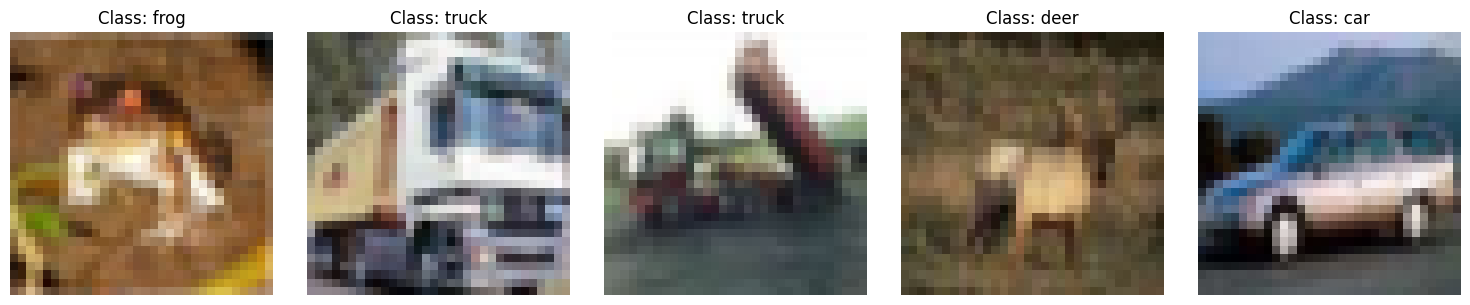

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")

def show_images(images, titles=None, cmap=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    if len(images) == 1:
        axes = [axes]
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0)
        axes[i].imshow(img, cmap=cmap)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

# Показываем несколько примеров
sample_images = [train_dataset[i][0] for i in range(5)]
show_images(sample_images, [f"Class: {classes[train_dataset[i][1]]}" for i in range(5)])

## A1. Базовая постановка

1) Предтекстовая задача:
   - Входы (X): Черно-белые изображения
   - Цели (Y): Цветные изображени
   
  Входы генерируются с помощью преобразования цветов у датасета в ЧБ по формуле

  grayscale = 0.2989 * R + 0.5870 * G + 0.1140 * B

  Генерация выходов формируется по архитектуре энкодера, результатами которого являются цветные изображения

  2)



## 2. Часть A: раскраска RGB в grayscale

In [ ]:
def rgb_to_grayscale_tensor(rgb_tensor):
    grayscale = 0.2989 * rgb_tensor[0] + 0.5870 * rgb_tensor[1] + 0.1140 * rgb_tensor[2]
    return grayscale.unsqueeze(0)

def grayscale_to_rgb_tensor(grayscale_tensor):
    return grayscale_tensor.repeat(3, 1, 1)

# Создание модели для раскраски
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()  # Выход в диапазоне [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Функции для вычисления метрик PSNR и SSIM
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


def calculate_ssim(img1, img2, window_size=11, size_average=True):
    # Упрощенная версия SSIM
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, window_size, 1, 0)
    mu2 = F.avg_pool2d(img2, window_size, 1, 0)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 * img1, window_size, 1, 0) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 * img2, window_size, 1, 0) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, 1, 0) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean() if size_average else ssim_map.mean(1).mean(1).mean(1)



In [ ]:
# Обучение

model_a1 = ColorizationModel().to(device)
optimizer_a1 = optim.Adam(model_a1.parameters(), lr=0.001)
criterion_mse = nn.MSELoss()

def train_colorization(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (rgb_images, _) in enumerate(train_loader):
            # Преобразуем RGB в grayscale
            grayscale_images = torch.stack([rgb_to_grayscale_tensor(img) for img in rgb_images])
            grayscale_images = grayscale_images.to(device)
            rgb_images = rgb_images.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(grayscale_images)
            loss = criterion(outputs, rgb_images)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    return train_losses

print("Обучение базовой модели с L2 лоссом...")
losses_a1 = train_colorization(model_a1, train_loader, optimizer_a1, criterion_mse, epochs=10)

Обучение базовой модели с L2 лоссом...
Epoch [1/10], Batch [100/391], Loss: 0.0106
Epoch [1/10], Batch [200/391], Loss: 0.0084
Epoch [1/10], Batch [300/391], Loss: 0.0072
Epoch [1/10], Average Loss: 0.0112
Epoch [2/10], Batch [100/391], Loss: 0.0081
Epoch [2/10], Batch [200/391], Loss: 0.0071
Epoch [2/10], Batch [300/391], Loss: 0.0068
Epoch [2/10], Average Loss: 0.0072
Epoch [3/10], Batch [100/391], Loss: 0.0065
Epoch [3/10], Batch [200/391], Loss: 0.0068
Epoch [3/10], Batch [300/391], Loss: 0.0070
Epoch [3/10], Average Loss: 0.0065
Epoch [4/10], Batch [100/391], Loss: 0.0059
Epoch [4/10], Batch [200/391], Loss: 0.0056
Epoch [4/10], Batch [300/391], Loss: 0.0057
Epoch [4/10], Average Loss: 0.0062
Epoch [5/10], Batch [100/391], Loss: 0.0049
Epoch [5/10], Batch [200/391], Loss: 0.0054
Epoch [5/10], Batch [300/391], Loss: 0.0061
Epoch [5/10], Average Loss: 0.0060
Epoch [6/10], Batch [100/391], Loss: 0.0072
Epoch [6/10], Batch [200/391], Loss: 0.0055
Epoch [6/10], Batch [300/391], Loss: 0

### Результаты обучения для A1

Оценка базовой модели:


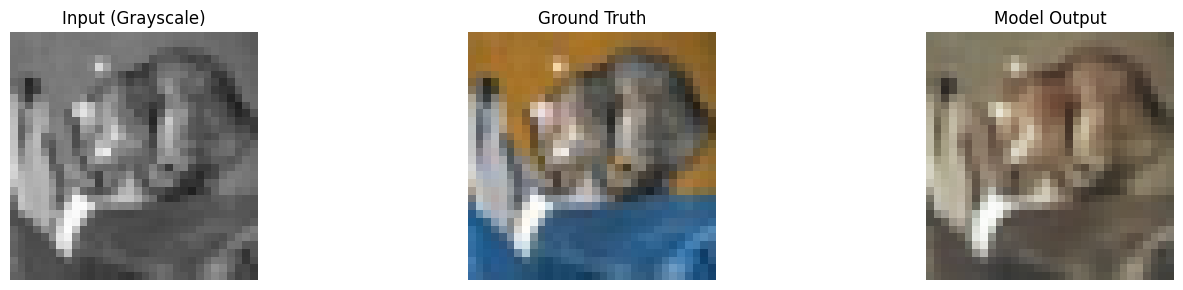

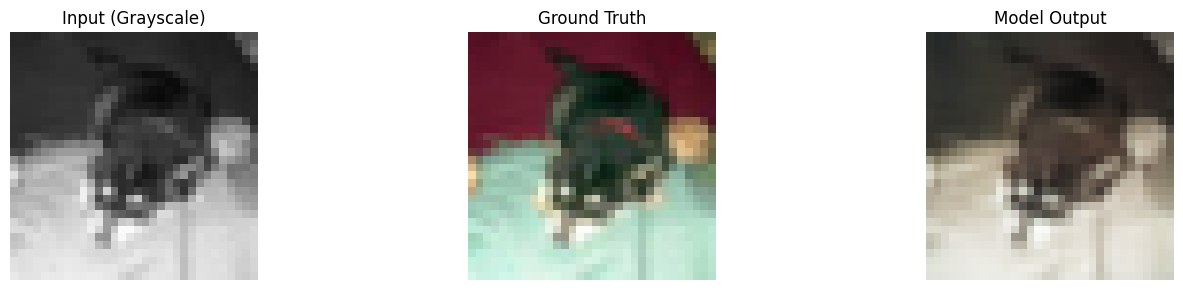

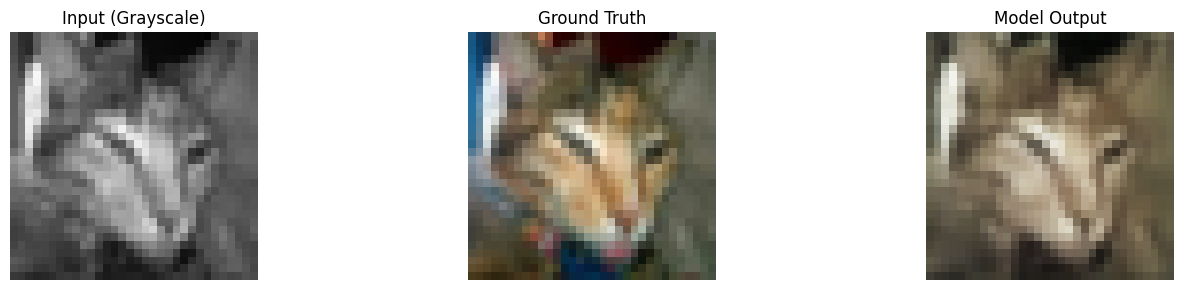

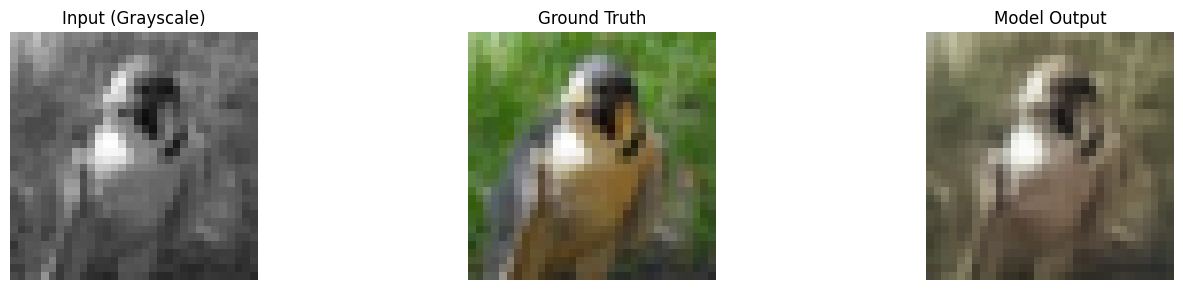

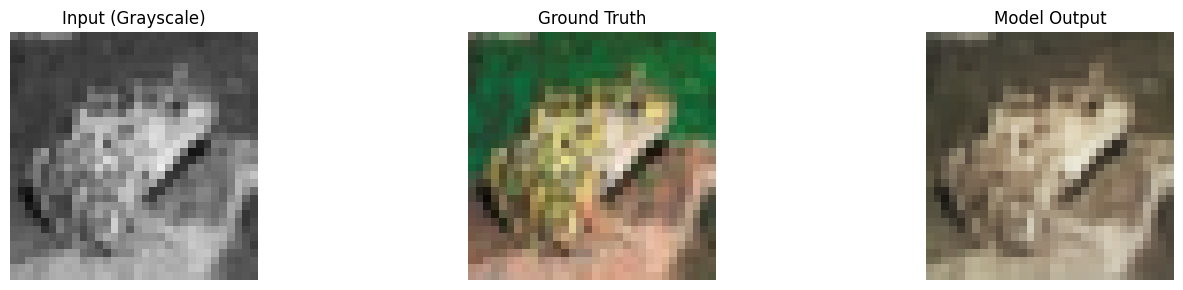

Average PSNR: 24.00
Average SSIM: 0.9438


In [ ]:
def evaluate_colorization(model, test_loader, num_samples=5):
    model.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for i, (rgb_images, _) in enumerate(test_loader):
            if i >= num_samples:
                break

            grayscale_images = torch.stack([rgb_to_grayscale_tensor(img) for img in rgb_images])
            grayscale_images = grayscale_images.to(device)
            rgb_images = rgb_images.to(device)

            outputs = model(grayscale_images)

            # Вычисляем метрики
            for j in range(min(3, len(rgb_images))):  # Берем первые 3 изображения из батча
                psnr = calculate_psnr(outputs[j], rgb_images[j])
                ssim = calculate_ssim(outputs[j].unsqueeze(0), rgb_images[j].unsqueeze(0))
                psnr_values.append(psnr.item())
                ssim_values.append(ssim.item())

            # Визуализируем первые 3 примера из первого батча
            #if i == 0:
            show_images([
                grayscale_to_rgb_tensor(grayscale_images[0].cpu()),
                rgb_images[0].cpu(),
                outputs[0].cpu()
            ], ['Input (Grayscale)', 'Ground Truth', 'Model Output'])

    return np.mean(psnr_values), np.mean(ssim_values)

print("Оценка базовой модели:")
psnr_a1, ssim_a1 = evaluate_colorization(model_a1, test_loader)
print(f"Average PSNR: {psnr_a1:.2f}")
print(f"Average SSIM: {ssim_a1:.4f}")

**Почему простой L2 давает «размытие» и усреднение?**

L2 loss минимизирует среднеквадратичную ошибку между предсказанием и целевым изображением. То есть модель усредненняет решения по всем возможным цветам для каждого пикселя. Вместо того чтобы выбирать наиболее вероятный цвет, модель усредняет все возможные варианты, что приводит к размытым и "мыльным" результатам.

## A2. Улучшение лосса

In [ ]:
class ImprovedColorizationModel(ColorizationModel):
    def __init__(self):
        super(ImprovedColorizationModel, self).__init__()

# Загрузка VGG для перцептуального лосса
vgg = models.vgg16(pretrained=True).features[:16].to(device)
for param in vgg.parameters():
    param.requires_grad = False

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg_layers = vgg_model
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3"
        }

    def forward(self, output, target):
        loss = 0.0
        output_features = output
        target_features = target

        for name, module in self.vgg_layers._modules.items():
            output_features = module(output_features)
            target_features = module(target_features)

            if name in self.layer_name_mapping:
                loss += F.mse_loss(output_features, target_features)

        return loss

def combined_loss(output, target, perceptual_loss_fn, alpha=0.5):
    mse_loss = criterion_mse(output, target)
    perceptual_loss = perceptual_loss_fn(output, target)
    return alpha * mse_loss + (1 - alpha) * perceptual_loss

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\gg/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [01:40<00:00, 5.53MB/s] 


In [ ]:
# Обучение улучшенной модели
model_a2 = ImprovedColorizationModel().to(device)
optimizer_a2 = optim.Adam(model_a2.parameters(), lr=0.001)
perceptual_loss_fn = PerceptualLoss(vgg)


def train_improved_colorization(model, train_loader, optimizer, epochs=10):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (rgb_images, _) in enumerate(train_loader):
            grayscale_images = torch.stack([rgb_to_grayscale_tensor(img) for img in rgb_images])
            grayscale_images = grayscale_images.to(device)
            rgb_images = rgb_images.to(device)

            optimizer.zero_grad()
            outputs = model(grayscale_images)
            loss = combined_loss(outputs, rgb_images, perceptual_loss_fn, alpha=0.7)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    return train_losses

losses_a2 = train_improved_colorization(model_a2, train_loader, optimizer_a2, epochs=10)


Epoch [1/10], Batch [100/391], Loss: 0.8996
Epoch [1/10], Batch [200/391], Loss: 0.6394
Epoch [1/10], Batch [300/391], Loss: 0.6631
Epoch [1/10], Average Loss: 0.8347
Epoch [2/10], Batch [100/391], Loss: 0.6298
Epoch [2/10], Batch [200/391], Loss: 0.5515
Epoch [2/10], Batch [300/391], Loss: 0.5608
Epoch [2/10], Average Loss: 0.5649
Epoch [3/10], Batch [100/391], Loss: 0.5595
Epoch [3/10], Batch [200/391], Loss: 0.5631
Epoch [3/10], Batch [300/391], Loss: 0.4943
Epoch [3/10], Average Loss: 0.5252
Epoch [4/10], Batch [100/391], Loss: 0.5241
Epoch [4/10], Batch [200/391], Loss: 0.5259
Epoch [4/10], Batch [300/391], Loss: 0.4789
Epoch [4/10], Average Loss: 0.5055
Epoch [5/10], Batch [100/391], Loss: 0.4497
Epoch [5/10], Batch [200/391], Loss: 0.4586
Epoch [5/10], Batch [300/391], Loss: 0.4342
Epoch [5/10], Average Loss: 0.4921
Epoch [6/10], Batch [100/391], Loss: 0.4356
Epoch [6/10], Batch [200/391], Loss: 0.4144
Epoch [6/10], Batch [300/391], Loss: 0.4836
Epoch [6/10], Average Loss: 0.484

Оценка улучшенной модели:

Результаты первой модели:


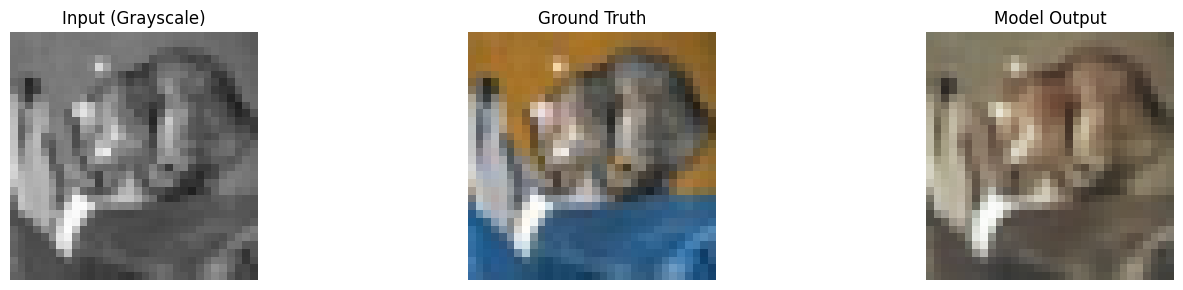

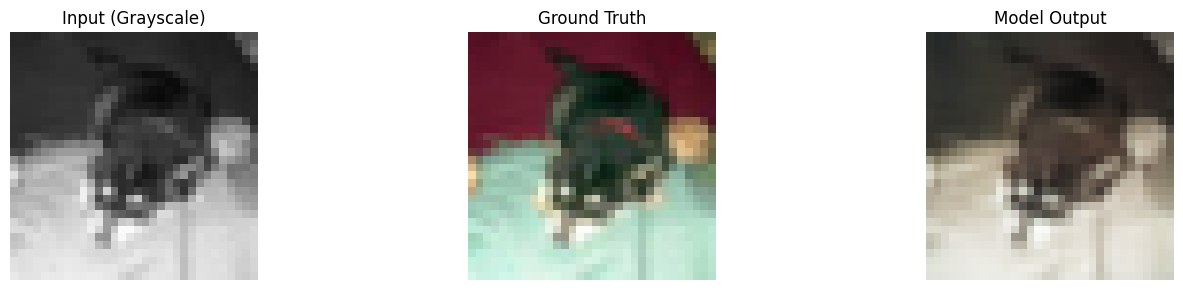

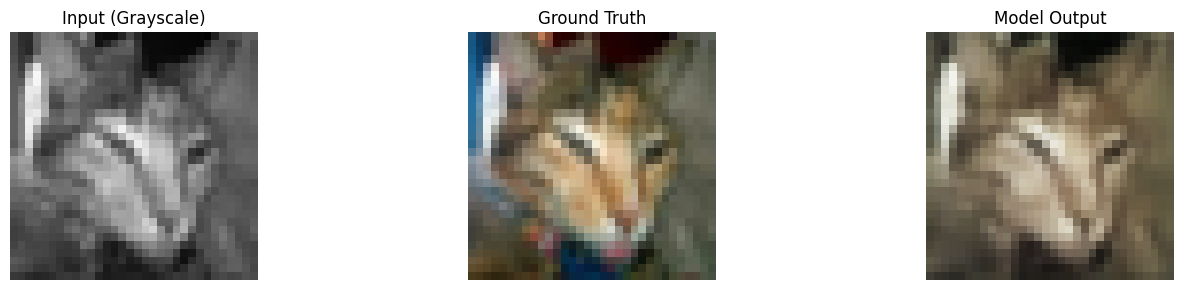


Результаты второй модели:


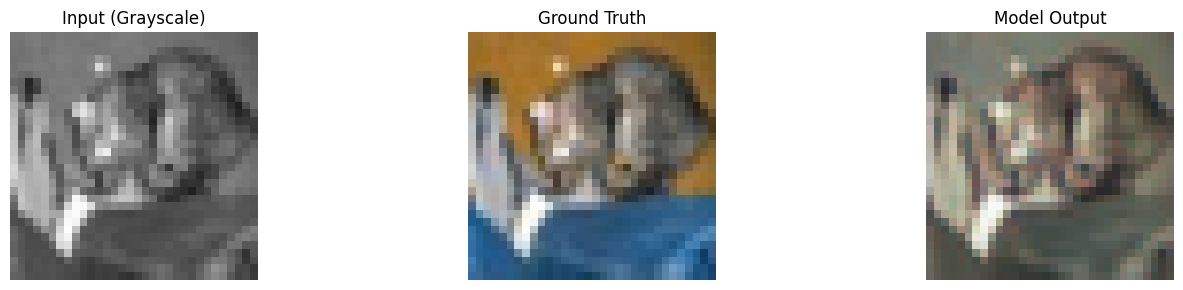

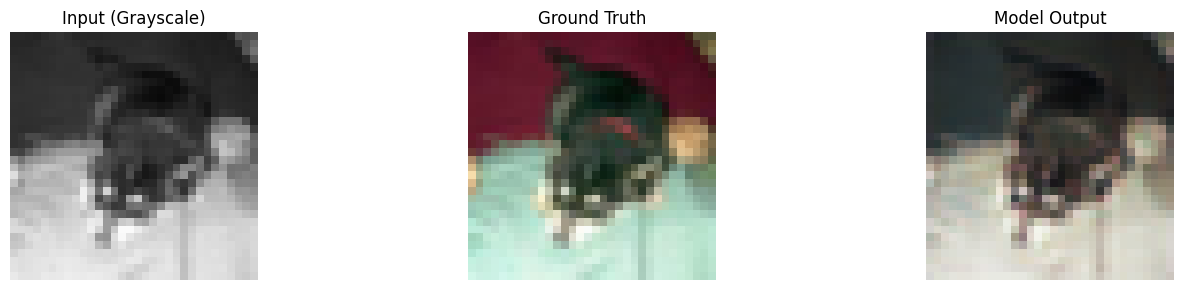

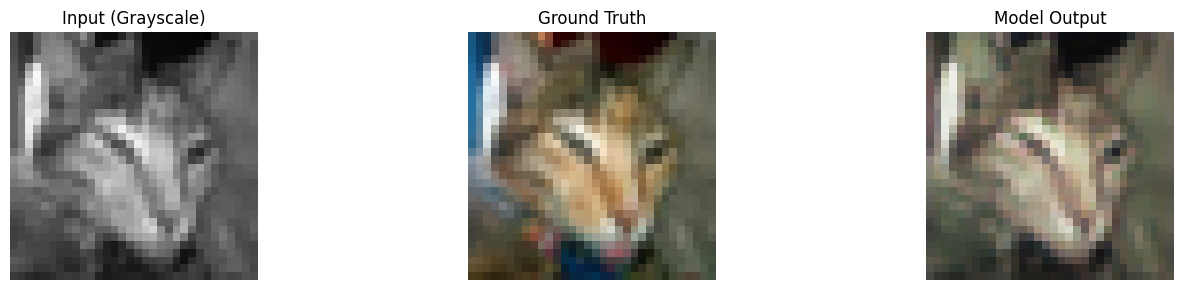

Average PSNR: 23.63
Average SSIM: 0.9334

Сравнение метрик:
PSNR: 23.49 (A1) vs 23.63 (A2)
SSIM: 0.9369 (A1) vs 0.9334 (A2)


In [ ]:
# Сравнение результатов A1 и A2
print("Оценка улучшенной модели:")
print("\nРезультаты первой модели:")
psnr_a1, ssim_a1 = evaluate_colorization(model_a1, test_loader, 3)
print("\nРезультаты второй модели:")
psnr_a2, ssim_a2 = evaluate_colorization(model_a2, test_loader, 3)

print(f"Average PSNR: {psnr_a2:.2f}")
print(f"Average SSIM: {ssim_a2:.4f}")

print("\nСравнение метрик:")
print(f"PSNR: {psnr_a1:.2f} (A1) vs {psnr_a2:.2f} (A2)")
print(f"SSIM: {ssim_a1:.4f} (A1) vs {ssim_a2:.4f} (A2)")

### Выводы

Видно, что первая модель по результатам обучения немного точнее, чем A2, но A2 лучше восстанавливает цвета и имеет более четкие границы.

## A3. Краткий анализ ошибок

"Галлюнации" можно заметить даже на примере выше. Видно, что обе модели подбирают цвета неточно, выбирая усредненные результаты из всех возможных сочетаний, стараясь избегать резких цветов. Как пример можно взять восстановление цвета у собаки: её границы стали менее заметны на общем фоне по сравнению с изначальными данными.

Как можно улучшить:
1. Улучшение аугментаций: Добавить более разнообразные преобразования цветов и контраста
2. Архитектурные улучшения: Использовать U-Net с skip-connections для сохранения деталей
3. Adversarial training: Добавить GAN-компонент для генерации более реалистичных цветов

# Часть B (контрастивное обучение SimCLR-подобно)

## B1. Пайплайн и функция потерь

In [ ]:
# Аугментации для контрастного обучения
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),  # Инвариантность к масштабу и позиции
    transforms.RandomHorizontalFlip(p=0.5),  # Инвариантность к зеркальному отражению
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Инвариантность к цвету
    transforms.RandomGrayscale(p=0.2),  # Инвариантность к цветовому пространству
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Инвариантность к детализации
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Базовые аугментации для линейного probe
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Загрузка данных
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Для контрастного обучения нужен отдельный датасет с аугментациями
# Берем исходные PIL изображения
cifar10_pil = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms.ToTensor())

### Аугментации
- RandomResizedCrop - модель учится узнавать объект в любом кадре
- RandomHorizontalFlip - модель учится узнавать объекты если они отражены
- ColorJitter - модель учится узнавать объекты при различных уровнях освещенности или при небольших изменениях цветов
- RandomGrayscale - модель распознает объекты в различных цветовых пространствах
- GaussianBlur - модель распознает объекты в различных уровнях детализации

In [ ]:
class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Получаем тензор и конвертируем его обратно в PIL для аугментаций
        img_tensor, _ = self.base_dataset[idx]

        # Конвертируем тензор в PIL Image
        img = transforms.ToPILImage()(img_tensor)

        # Применяем аугментации
        view1 = contrastive_transform(img)
        view2 = contrastive_transform(img)

        return view1, view2

contrastive_dataset = ContrastiveDataset(cifar10_pil)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=256, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")
print(f"Размер датасета для контрастного обучения: {len(contrastive_dataset)}")

Размер тренировочного датасета: 50000
Размер тестового датасета: 10000
Размер датасета для контрастного обучения: 50000


In [ ]:

# Модель энкодера (упрощенная версия ResNet)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Encoder(nn.Module):
    def __init__(self, feature_dim=128):
        super(Encoder, self).__init__()

        # Первый слой
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Блоки ResNet
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Средний пуллинг
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Проекционная головка
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x, return_features=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        projection = self.projector(features)

        if return_features:
            return features, projection
        return projection

# Функция потерь InfoNCE
def info_nce_loss(z1, z2, temperature=0.5):
    """Вычисляет контрастную потерь InfoNCE между двумя представлениями."""
    batch_size = z1.shape[0]

    # Нормализуем векторы
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Объединяем все представления
    representations = torch.cat([z1, z2], dim=0)

    # Матрица косинусных сходств
    similarity_matrix = F.cosine_similarity(
        representations.unsqueeze(1),
        representations.unsqueeze(0),
        dim=2
    )

    # Маска для положительных пар
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z1.device)
    mask = mask.roll(batch_size, dims=0)

    # Извлекаем положительные сходства
    positives = similarity_matrix[mask].view(2 * batch_size, 1)

    # Извлекаем отрицательные сходства
    negatives = similarity_matrix[~mask].view(2 * batch_size, -1)

    # Вычисляем лосс по формуле InfoNCE
    logits = torch.cat([positives, negatives], dim=1) / temperature
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z1.device)

    loss = F.cross_entropy(logits, labels)
    return loss


In [ ]:
# Обучение энкодера
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(feature_dim=128).to(device)
optimizer = optim.Adam(encoder.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

print("\n=== Обучение энкодера с InfoNCE ===")
encoder.train()
for epoch in range(10):
    total_loss = 0
    progress_bar = tqdm(contrastive_loader, desc=f'Epoch {epoch+1}/10')

    for batch_idx, (view1, view2) in enumerate(progress_bar):
        view1, view2 = view1.to(device), view2.to(device)

        # Получаем представления
        z1 = encoder(view1)
        z2 = encoder(view2)

        # Вычисляем лосс
        loss = info_nce_loss(z1, z2, temperature=0.5)

        # Оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    scheduler.step()
    print(f'Epoch {epoch+1}, Average Loss: {total_loss/len(contrastive_loader):.4f}')

# Сохраняем энкодер
torch.save(encoder.state_dict(), 'encoder_contrastive.pth')


=== Обучение энкодера с InfoNCE ===


Epoch 1/10: 100%|██████████| 196/196 [03:24<00:00,  1.04s/it, loss=3.99]


Epoch 1, Average Loss: 5.3181


Epoch 2/10: 100%|██████████| 196/196 [03:21<00:00,  1.03s/it, loss=3.9]


Epoch 2, Average Loss: 5.0653


Epoch 3/10: 100%|██████████| 196/196 [03:22<00:00,  1.03s/it, loss=3.82]


Epoch 3, Average Loss: 4.9693


Epoch 4/10: 100%|██████████| 196/196 [03:20<00:00,  1.02s/it, loss=3.73]


Epoch 4, Average Loss: 4.9113


Epoch 5/10: 100%|██████████| 196/196 [03:20<00:00,  1.03s/it, loss=3.74]


Epoch 5, Average Loss: 4.8725


Epoch 6/10: 100%|██████████| 196/196 [03:22<00:00,  1.03s/it, loss=3.65]


Epoch 6, Average Loss: 4.8399


Epoch 7/10: 100%|██████████| 196/196 [03:23<00:00,  1.04s/it, loss=3.64]


Epoch 7, Average Loss: 4.8181


Epoch 8/10: 100%|██████████| 196/196 [03:23<00:00,  1.04s/it, loss=3.6]


Epoch 8, Average Loss: 4.7991


Epoch 9/10: 100%|██████████| 196/196 [03:22<00:00,  1.03s/it, loss=3.61]


Epoch 9, Average Loss: 4.7879


Epoch 10/10: 100%|██████████| 196/196 [03:22<00:00,  1.04s/it, loss=3.64]

Epoch 10, Average Loss: 4.7773



Всего параметров: 11,497,152
Обучаемых параметров: 11,497,152
Норма весов слоя conv1.weight: 4.6143
Норма весов слоя layer1.0.conv1.weight: 4.9187
Норма весов слоя layer1.0.conv2.weight: 4.9420
Норма весов слоя layer1.1.conv1.weight: 4.9603
Норма весов слоя layer1.1.conv2.weight: 4.9416
Норма весов слоя layer2.0.conv1.weight: 7.0469
Норма весов слоя layer2.0.conv2.weight: 7.5348
Норма весов слоя layer2.0.shortcut.0.weight: 6.6569
Норма весов слоя layer2.1.conv1.weight: 7.6109
Норма весов слоя layer2.1.conv2.weight: 7.6044
Норма весов слоя layer3.0.conv1.weight: 10.8053
Норма весов слоя layer3.0.conv2.weight: 12.0607
Норма весов слоя layer3.0.shortcut.0.weight: 9.4753
Норма весов слоя layer3.1.conv1.weight: 12.1783
Норма весов слоя layer3.1.conv2.weight: 11.9099
Норма весов слоя layer4.0.conv1.weight: 16.8381
Норма весов слоя layer4.0.conv2.weight: 19.0147
Норма весов слоя layer4.0.shortcut.0.weight: 13.6098
Норма весов слоя layer4.1.conv1.weight: 18.5200
Норма весов слоя layer4.1.conv

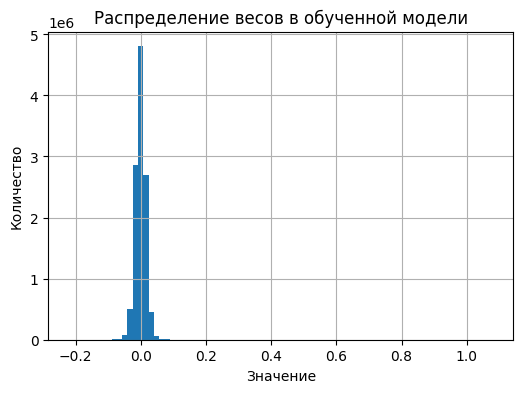


=== Пример выхода модели ===
tensor([[ 3.9375e-01,  1.5035e-02,  1.4297e-01,  1.0854e-01, -2.1808e-01,
          2.8067e-01, -6.0885e-01,  8.6448e-02, -2.9743e-01, -2.1338e-01,
          4.4992e-02,  1.7847e-01,  1.1101e-01,  9.6024e-02,  1.9504e-01,
         -5.2629e-02, -6.5278e-02,  2.8446e-01,  9.6552e-02,  5.1859e-02,
          2.8752e-01,  6.8267e-01, -4.9762e-02,  1.5334e-01,  1.5774e-01,
         -9.6323e-02, -4.1706e-01,  3.5099e-01,  2.2518e-01,  2.5473e-01,
         -2.0276e-02, -5.1659e-01, -5.2611e-02,  7.1029e-02, -1.4185e-01,
         -4.8069e-02, -1.8589e-01,  1.0125e-01,  3.8538e-01,  8.3549e-02,
          2.2541e-01,  2.8737e-01,  5.2639e-01, -5.5763e-02,  1.3654e-01,
         -1.1500e-01,  1.2953e-01, -2.8732e-01,  2.5783e-01, -4.5552e-04,
          9.5561e-02,  1.2932e-01,  1.9051e-02, -9.6203e-02, -4.6650e-01,
         -2.3025e-01,  5.5396e-02, -3.1499e-01, -2.2644e-01, -4.9208e-02,
          4.2554e-01,  3.0225e-01, -4.6801e-01, -1.1036e-01,  2.2369e-01,
        

In [ ]:
total_params = sum(p.numel() for p in encoder.parameters())
trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

# Нормы весов (для стабильности модели)
weight_norms = []
for name, param in encoder.named_parameters():
    if param.dim() > 1:  # исключаем bias
        norm = param.data.norm().item()
        weight_norms.append(norm)
        print(f"Норма весов слоя {name}: {norm:.4f}")

# Гистограмма весов
plt.figure(figsize=(6, 4))
all_weights = torch.cat([p.data.flatten() for p in encoder.parameters()])
plt.hist(all_weights.cpu().numpy(), bins=80)
plt.title("Распределение весов в обученной модели")
plt.xlabel("Значение")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

# Проверка выхода модели на случайных данных
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = encoder(dummy_input)

print("\n=== Пример выхода модели ===")
print(output)
print("Размер выхода:", output.shape)

# Проверка L2-нормы эмбеддингов (должна быть близка к 1 после normalize)
print("\n=== Норма выхода ===")
print(output.norm().item())

## B2 Линейный probe

In [ ]:
class LinearProbe(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(LinearProbe, self).__init__()
        self.encoder = encoder
        # Замораживаем энкодер
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Получаем размерность фичей
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 32, 32).to(device)
            features, _ = self.encoder(dummy_input, return_features=True)
            feature_dim = features.shape[1]

        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        features, _ = self.encoder(x, return_features=True)
        return self.classifier(features)


In [ ]:
# Создаем и обучаем линейный классификатор
linear_model = LinearProbe(encoder).to(device)
criterion = nn.CrossEntropyLoss()
probe_optimizer = optim.Adam(linear_model.classifier.parameters(), lr=1e-3)

print("\n=== Обучение линейного классификатора ===")
linear_model.train()
for epoch in range(10):
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/10'):
        images, labels = images.to(device), labels.to(device)

        outputs = linear_model(images)
        loss = criterion(outputs, labels)

        probe_optimizer.zero_grad()
        loss.backward()
        probe_optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


=== Обучение линейного классификатора ===


Epoch 1/10: 100%|██████████| 391/391 [00:24<00:00, 16.07it/s]


Epoch 1, Loss: 1.2038, Accuracy: 56.86%


Epoch 2/10: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]


Epoch 2, Loss: 1.1043, Accuracy: 60.39%


Epoch 3/10: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Epoch 3, Loss: 1.0794, Accuracy: 61.37%


Epoch 4/10: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s]


Epoch 4, Loss: 1.0627, Accuracy: 61.91%


Epoch 5/10: 100%|██████████| 391/391 [00:23<00:00, 16.48it/s]


Epoch 5, Loss: 1.0514, Accuracy: 62.47%


Epoch 6/10: 100%|██████████| 391/391 [00:23<00:00, 16.79it/s]


Epoch 6, Loss: 1.0369, Accuracy: 62.89%


Epoch 7/10: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


Epoch 7, Loss: 1.0270, Accuracy: 63.36%


Epoch 8/10: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]


Epoch 8, Loss: 1.0214, Accuracy: 63.45%


Epoch 9/10: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]


Epoch 9, Loss: 1.0113, Accuracy: 63.96%


Epoch 10/10: 100%|██████████| 391/391 [00:23<00:00, 16.40it/s]

Epoch 10, Loss: 1.0083, Accuracy: 63.87%



=== Оценка линейного классификатора ===


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


Точность (top-1) на тесте: 64.79%


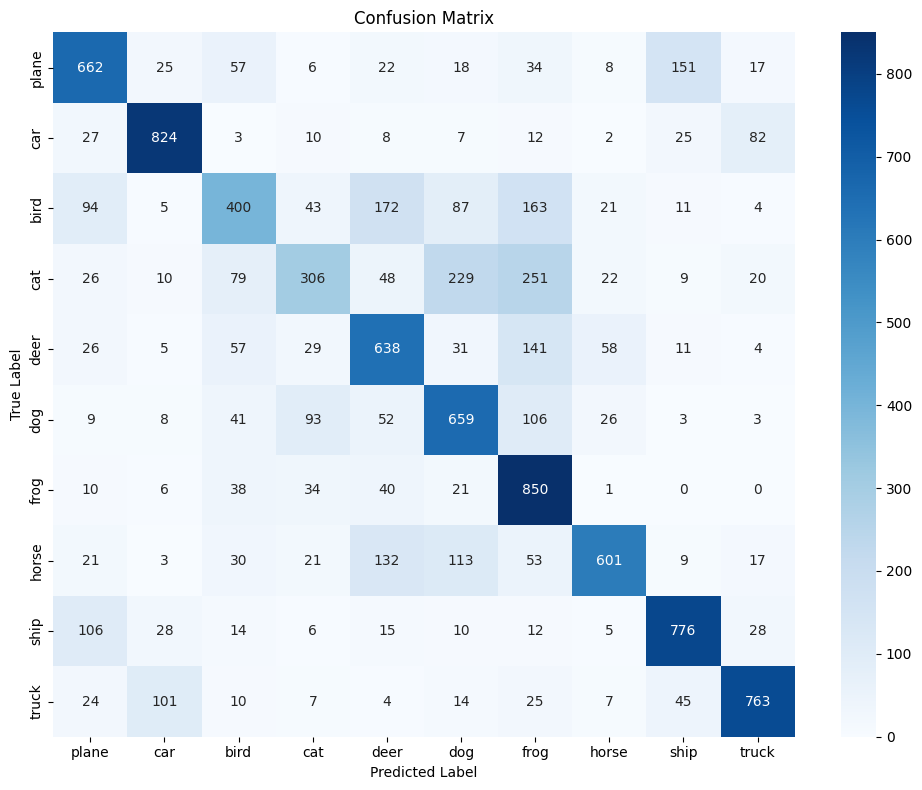

In [ ]:
# Оценка модели
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_features = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)

            # Получаем предсказания и фичи
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Получаем фичи из энкодера
            features, _ = model.encoder(images, return_features=True)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_features.append(features.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    all_features = np.vstack(all_features)

    return accuracy, all_preds, all_labels, all_features

print("\n=== Оценка линейного классификатора ===")
test_accuracy, preds, labels, features = evaluate_model(linear_model, test_loader)
print(f"Точность (top-1) на тесте: {test_accuracy:.2f}%")

# Матрица ошибок
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Выводы

Модель научилась извлекать признаки авто и лягушек, но хуже всего справляется с котами. После обучения видно, что модель чаще всего будет хорошо справляться с поставленной задачей классификацией, но точность далеко не самая лучшая.


=== t-SNE визуализация эмбеддингов ===


Extracting features (before): 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]


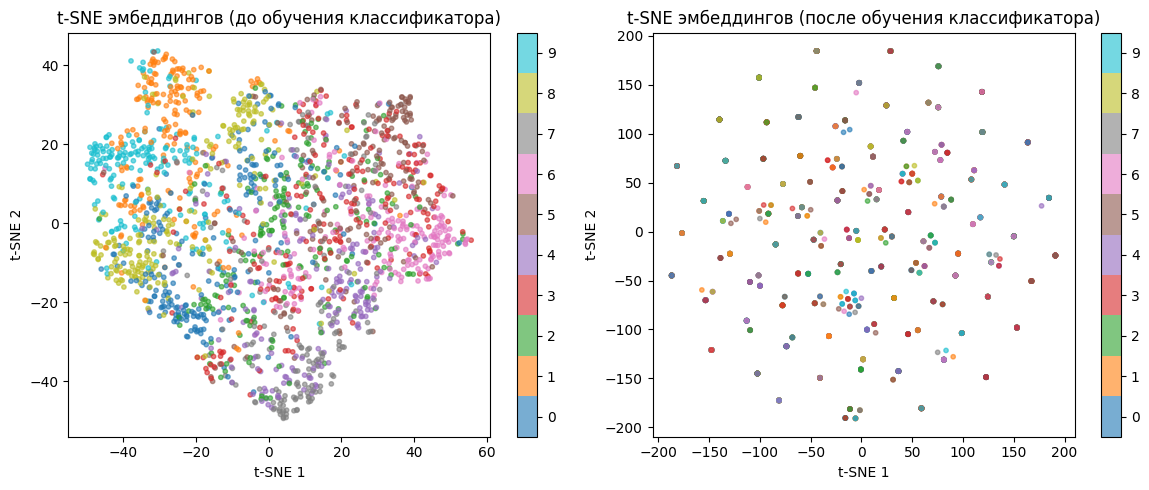

In [ ]:
#print(classification_report(labels, preds, target_names=classes))

# t-SNE визуализация (до обучения классификатора)
print("\n=== t-SNE визуализация эмбеддингов ===")

# Получаем эмбеддинги до обучения классификатора
encoder.eval()
train_features_before = []
train_labels_before = []

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Extracting features (before)'):
        images = images.to(device)
        features, _ = encoder(images, return_features=True)
        train_features_before.append(features.cpu().numpy())
        train_labels_before.extend(labels.numpy())

train_features_before = np.vstack(train_features_before)
train_labels_before = np.array(train_labels_before)

# Берем подвыборку для t-SNE
subset_indices = np.random.choice(len(train_features_before), 2000, replace=False)
features_subset = train_features_before[subset_indices]
labels_subset = train_labels_before[subset_indices]

# t-SNE для эмбеддингов ДО обучения классификатора
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d_before = tsne.fit_transform(features_subset)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(features_2d_before[:, 0], features_2d_before[:, 1],
                      c=labels_subset, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('t-SNE эмбеддингов (до обучения классификатора)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# t-SNE для эмбеддингов ПОСЛЕ обучения классификатора
features_subset_after = features[subset_indices % len(features)]
features_subset_after = features_subset_after.cpu().numpy()
features_2d_after = tsne.fit_transform(features_subset_after)

plt.subplot(1, 2, 2)
scatter = plt.scatter(features_2d_after[:, 0], features_2d_after[:, 1],
                      c=labels_subset, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('t-SNE эмбеддингов (после обучения классификатора)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()


## B3. Малые Абляции


Обучение с температурой τ=0.1
  Epoch 1, Loss: 4.4132
  Epoch 2, Loss: 3.4018
  Epoch 3, Loss: 3.0511
  Epoch 4, Loss: 2.8955
  Probe Epoch 1, Accuracy: 50.68%
  Probe Epoch 2, Accuracy: 55.62%
  Probe Epoch 3, Accuracy: 56.61%
Температура: 0.1, Точность линейного probe: 56.61%

Обучение с температурой τ=0.5
  Epoch 1, Loss: 5.3177
  Epoch 2, Loss: 5.0507
  Epoch 3, Loss: 4.9642
  Epoch 4, Loss: 4.9041
  Probe Epoch 1, Accuracy: 46.77%
  Probe Epoch 2, Accuracy: 51.61%
  Probe Epoch 3, Accuracy: 52.48%
Температура: 0.5, Точность линейного probe: 52.48%

Обучение с температурой τ=1.0
  Epoch 1, Loss: 5.6958
  Epoch 2, Loss: 5.5875
  Epoch 3, Loss: 5.5495
  Epoch 4, Loss: 5.5258
  Probe Epoch 1, Accuracy: 42.17%
  Probe Epoch 2, Accuracy: 46.47%
  Probe Epoch 3, Accuracy: 47.79%
Температура: 1.0, Точность линейного probe: 47.79%


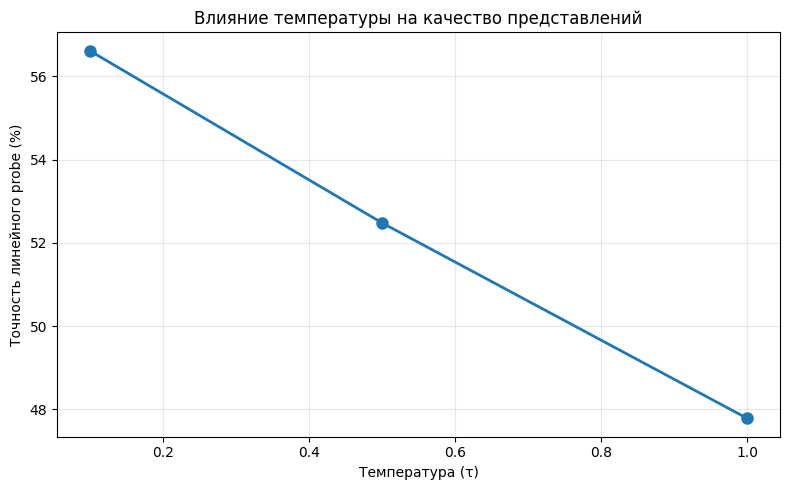

In [ ]:
# Эксперимент 1: Разные значения температуры
temperatures = [ 0.1, 0.5, 1.0]
temp_results = []

for temp in temperatures:
    print(f"\nОбучение с температурой τ={temp}")

    # Создаем новый энкодер
    temp_encoder = Encoder(feature_dim=128).to(device)
    temp_optimizer = optim.Adam(temp_encoder.parameters(), lr=3e-4)

    # Короткое обучение для оценки
    temp_encoder.train()
    temp_losses = []

    for epoch in range(4):  # Быстрое обучение для оценки
        epoch_loss = 0
        # Используем num_workers=0 или небольшое значение, чтобы избежать проблем с multiprocessing
        contrastive_loader = DataLoader(contrastive_dataset, batch_size=256,
                                        shuffle=True, pin_memory=True)

        for view1, view2 in contrastive_loader:
            view1, view2 = view1.to(device), view2.to(device)

            z1 = temp_encoder(view1)
            z2 = temp_encoder(view2)

            loss = info_nce_loss(z1, z2, temperature=temp)

            temp_optimizer.zero_grad()
            loss.backward()
            temp_optimizer.step()

            epoch_loss += loss.item()

        temp_losses.append(epoch_loss / len(contrastive_loader))
        print(f"  Epoch {epoch+1}, Loss: {temp_losses[-1]:.4f}")

    # Оцениваем качество линейным probe
    temp_linear = LinearProbe(temp_encoder).to(device)
    temp_criterion = nn.CrossEntropyLoss()
    temp_probe_optimizer = optim.Adam(temp_linear.classifier.parameters(), lr=1e-3)

    # Быстрое обучение линейного классификатора
    temp_linear.train()
    temp_accuracies = []

    # Создаем train_loader без многопроцессорности для избежания ошибок
    train_loader_no_mp = DataLoader(train_dataset, batch_size=256,
                                    shuffle=True,  pin_memory=True)

    for epoch in range(3):
        correct = 0
        total = 0

        for images, labels in train_loader_no_mp:
            images, labels = images.to(device), labels.to(device)

            outputs = temp_linear(images)
            loss = temp_criterion(outputs, labels)

            temp_probe_optimizer.zero_grad()
            loss.backward()
            temp_probe_optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100. * correct / total
        temp_accuracies.append(accuracy)
        print(f"  Probe Epoch {epoch+1}, Accuracy: {accuracy:.2f}%")

    final_accuracy = temp_accuracies[-1]
    temp_results.append((temp, final_accuracy))
    print(f"Температура: {temp}, Точность линейного probe: {final_accuracy:.2f}%")

# Визуализация результатов температуры
plt.figure(figsize=(8, 5))
temps, accs = zip(*temp_results)
plt.plot(temps, accs, 'o-', linewidth=2, markersize=8)
plt.xlabel('Температура (τ)')
plt.ylabel('Точность линейного probe (%)')
plt.title('Влияние температуры на качество представлений')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





### Выводы

Получилось проверить только для изменения температур (на большее не хватило времени в колабе). Можно заметить, что при увеличении температуры, точность снижается, но процесс обучения ускоряется.

# Часть C (zero-shot с CLIP и сравнение)

## C1. Zero-shot классификация


Загрузка модели CLIP...


100%|███████████████████████████████████████| 338M/338M [01:07<00:00, 5.28MiB/s]


Модель CLIP загружена!

Тестирование CLIP на нескольких примерах из тестового набора:


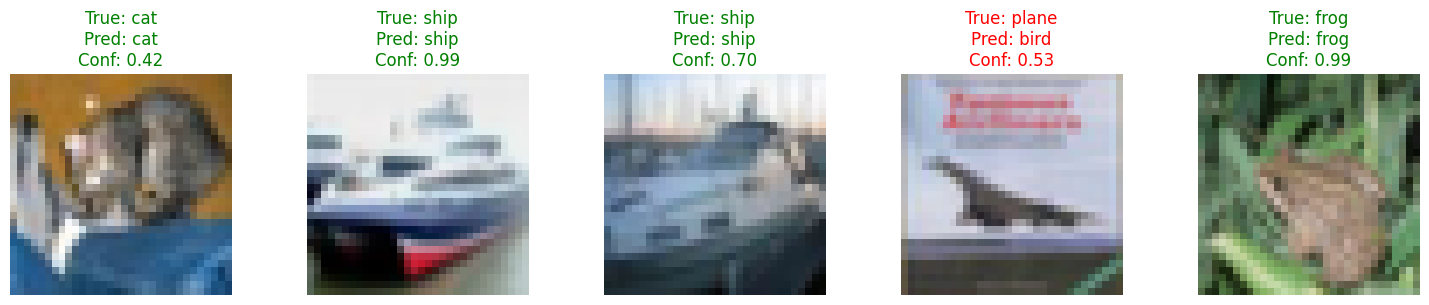

In [ ]:
# Загрузка предобученной модели CLIP
print("Загрузка модели CLIP...")
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
print("Модель CLIP загружена!")

# Функция для предсказания с помощью CLIP
def classify_with_clip(images, labels=None):
    """Классификация изображений с помощью CLIP"""
    # Подготовка текстовых описаний классов
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    # Извлечение текстовых признаков
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    predictions = []
    probabilities = []
    all_image_features = []

    # Обработка батчами
    with torch.no_grad():
        # Нормализация изображений для CLIP
        images = images.to(device)

        # Извлечение визуальных признаков
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features.cpu())

        # Вычисление сходства
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Получение предсказаний
        probs, indices = similarity.topk(5, dim=1)

        for i in range(len(images)):
            predictions.append(indices[i][0].item())
            probabilities.append(probs[i][0].item())

    return predictions, probabilities, torch.cat(all_image_features, dim=0)

# Тестирование CLIP на нескольких примерах
print("\nТестирование CLIP на нескольких примерах из тестового набора:")
test_samples = []
test_labels = []
for i in range(5):
    image, label = test_dataset[i]
    test_samples.append(image)
    test_labels.append(label)

# Подготовка изображений для CLIP (применяем преобразования CLIP)
clip_images = torch.stack([preprocess(Image.fromarray((img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)))
                          for img in test_samples]).to(device)

predictions, probs, _ = classify_with_clip(clip_images)

# Визуализация результатов
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = test_samples[i].permute(1, 2, 0)
    axes[i].imshow(img)
    true_label = classes[test_labels[i]]
    pred_label = classes[predictions[i]]
    confidence = probs[i]

    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=color)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Оценка точности CLIP на части тестового набора

100%|██████████| 32/32 [00:01<00:00, 18.70it/s]


Точность CLIP на 1000 изображениях: 90.60%

Визуализация признаков CLIP с помощью t-SNE...


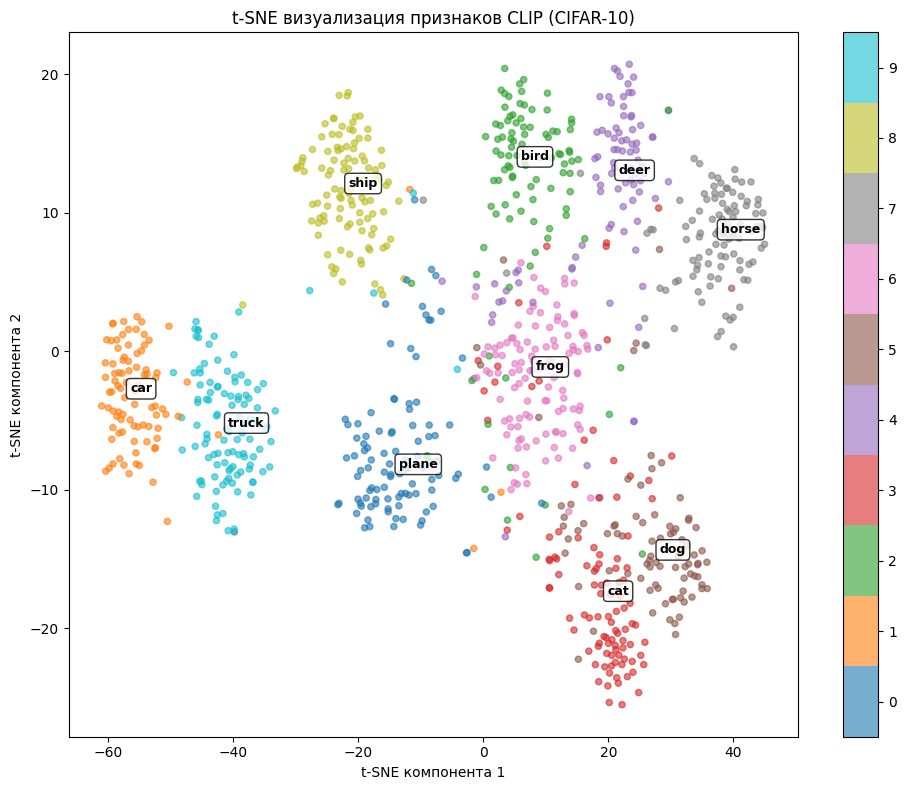

In [ ]:
num_samples = 1000
correct = 0
total = 0
all_features = []
all_labels = []

with torch.no_grad():
    for i in tqdm(range(0, min(num_samples, len(test_dataset)), 32)):
        batch_indices = list(range(i, min(i + 32, num_samples)))
        batch_images = []
        batch_labels = []

        for idx in batch_indices:
            image, label = test_dataset[idx]
            # Преобразуем в PIL Image и применяем препроцессинг CLIP
            pil_img = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
            batch_images.append(preprocess(pil_img))
            batch_labels.append(label)

        batch_images = torch.stack(batch_images).to(device)
        batch_labels = torch.tensor(batch_labels).to(device)

        predictions, _, features = classify_with_clip(batch_images, batch_labels)

        # Сравниваем предсказания с истинными метками
        for j in range(len(predictions)):
            if predictions[j] == batch_labels[j].item():
                correct += 1
            total += 1

        all_features.append(features)
        all_labels.append(batch_labels.cpu())

all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

accuracy = correct / total * 100
print(f"Точность CLIP на {total} изображениях: {accuracy:.2f}%")

# Визуализация признаков с помощью t-SNE
print("\nВизуализация признаков CLIP с помощью t-SNE...")
tsne = TSNE(n_components=2, random_state=seed, perplexity=30)
features_2d = tsne.fit_transform(all_features.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels.numpy(),
                      cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('t-SNE визуализация признаков CLIP (CIFAR-10)')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')

# Добавляем названия классов
for i, class_name in enumerate(classes):
    class_indices = np.where(all_labels.numpy() == i)[0]
    if len(class_indices) > 0:
        median_pos = np.median(features_2d[class_indices], axis=0)
        plt.annotate(class_name, median_pos, fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


### Выводы

Разница в точности около 30%, это существенная разница в пользу CLIP, очевидно, что предпочтительнее использовать предобученную модель.

### Матрица ошибок для CLIP

100%|██████████| 32/32 [00:01<00:00, 18.93it/s]


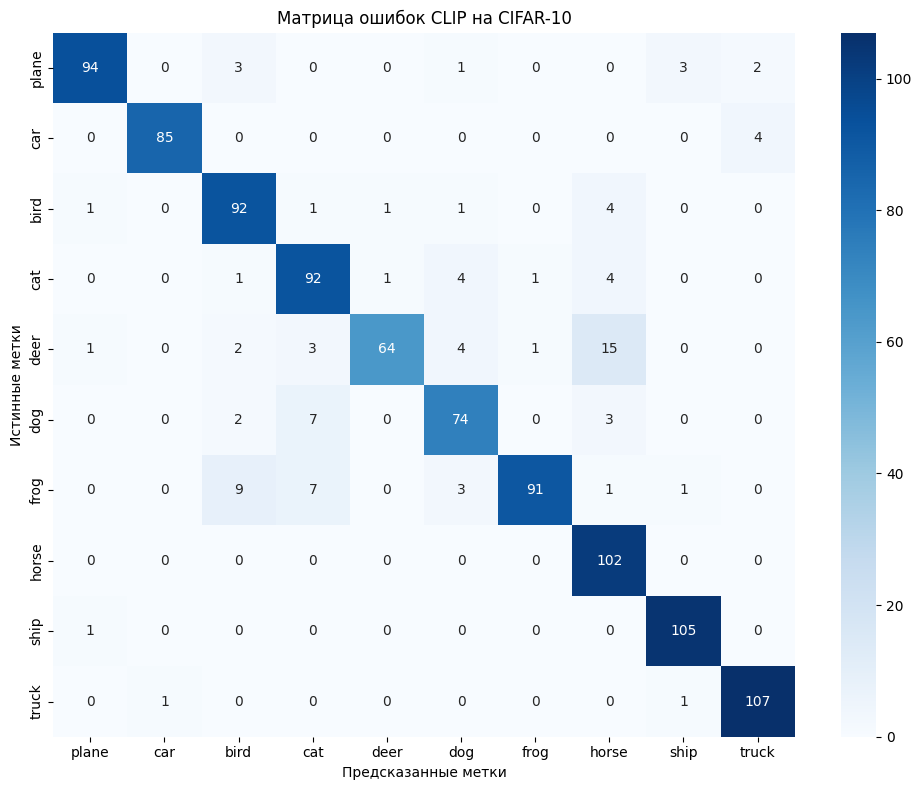

In [ ]:
# Получаем все предсказания для выборки
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for i in tqdm(range(0, min(num_samples, len(test_dataset)), 32)):
        batch_indices = list(range(i, min(i + 32, num_samples)))
        batch_images = []
        batch_labels = []

        for idx in batch_indices:
            image, label = test_dataset[idx]
            pil_img = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
            batch_images.append(preprocess(pil_img))
            batch_labels.append(label)

        batch_images = torch.stack(batch_images).to(device)
        batch_labels = torch.tensor(batch_labels)

        predictions, _, _ = classify_with_clip(batch_images)

        all_predictions.extend(predictions)
        all_true_labels.extend(batch_labels.numpy())

# Вычисляем матрицу ошибок
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Матрица ошибок CLIP на CIFAR-10')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.tight_layout()
plt.show()


## Отчет о классификации

              precision    recall  f1-score   support

       plane       0.97      0.91      0.94       103
         car       0.99      0.96      0.97        89
        bird       0.84      0.92      0.88       100
         cat       0.84      0.89      0.86       103
        deer       0.97      0.71      0.82        90
         dog       0.85      0.86      0.86        86
        frog       0.98      0.81      0.89       112
       horse       0.79      1.00      0.88       102
        ship       0.95      0.99      0.97       106
       truck       0.95      0.98      0.96       109

    accuracy                           0.91      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.91      0.91      1000



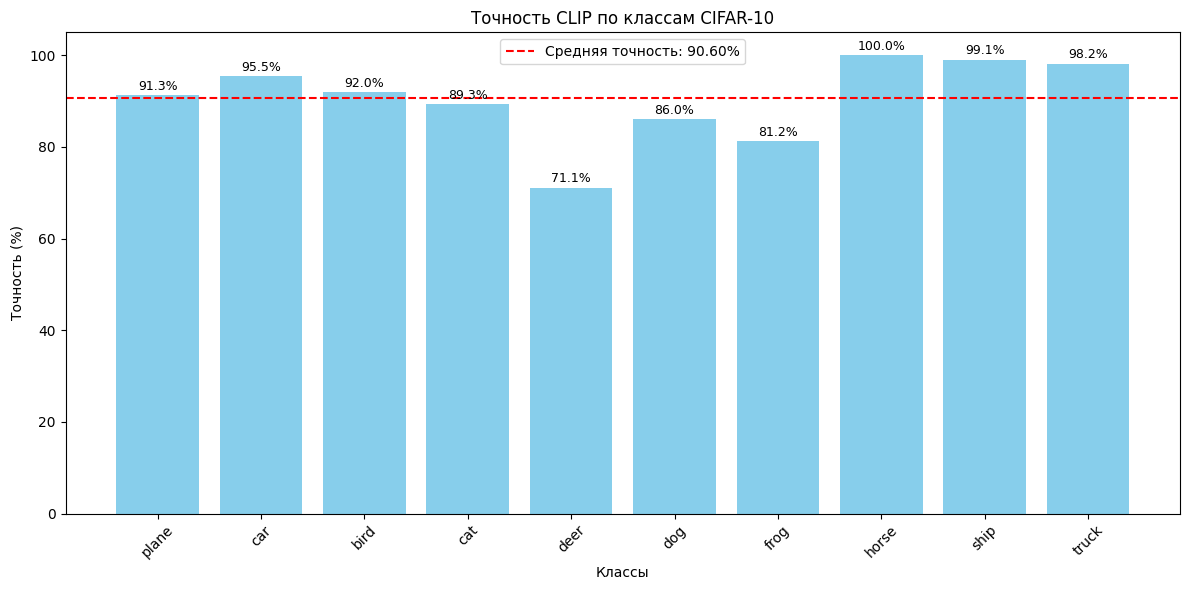

In [ ]:
print(classification_report(all_true_labels, all_predictions, target_names=classes))

# Сравнение точности по классам
class_accuracies = []
for i in range(10):
    class_indices = np.where(np.array(all_true_labels) == i)[0]
    if len(class_indices) > 0:
        class_correct = sum(1 for idx in class_indices if all_predictions[idx] == i)
        class_acc = class_correct / len(class_indices) * 100
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

# Визуализация точности по классам
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, class_accuracies, color='skyblue')
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Средняя точность: {accuracy:.2f}%')
plt.xlabel('Классы')
plt.ylabel('Точность (%)')
plt.title('Точность CLIP по классам CIFAR-10')
plt.xticks(rotation=45)
plt.legend()

# Добавляем значения на столбцы
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nИтоговая точность CLIP на CIFAR-10: {accuracy:.2f}%")


### Выводы

- Мультимодальность: текст и изображения позволяет лучше выделять смысловые признаки, а не только визуальное представление
- Промпт-инжиниринг: добавляет контекст к изображению, что помогает выделять признаки через текст.